<H1>Import all Necessary library</H1>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance,plot_tree
plt.style.use('fivethirtyeight')
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Read training and Test data

In [2]:
df_train=pd.read_csv('train_hackathon.csv',parse_dates=['date'],)
df_test=pd.read_csv('test_hackathon.csv',parse_dates=['date'],)

In [3]:
print("Training data shape : ",df_train.shape)
print("Test data shape : ",df_test.shape)

Training data shape :  (18247, 3)
Test data shape :  (7650, 2)


# Check if we have any null values in the training set 

In [4]:
df_train.isnull().sum()

date      0
hour      0
demand    0
dtype: int64

# describe Training set 

In [5]:
df_train.describe()

,hour,demand
count,18247.000000,18247.000000
mean,12.614731,73.991451
std,6.544963,41.678988
min,0.000000,1.000000
25%,8.000000,43.000000
50%,13.000000,71.000000
75%,18.000000,98.000000
max,23.000000,379.000000


# check if any duplicate value present in train data

In [6]:
df_train.drop_duplicates()

# No duplicates as shape of data doesn't changes 

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81
...,...,...,...
18242,2021-02-28,19,95
18243,2021-02-28,20,88
18244,2021-02-28,21,39
18245,2021-02-28,22,104


In [7]:
df_train=df_train.set_index('date')

In [8]:
df_train.head()

,hour,demand
date,,
2018-08-18,9,91
2018-08-18,10,21
2018-08-18,13,23
2018-08-18,14,104
2018-08-18,15,81


In [9]:
df_test=df_test.set_index('date')

In [10]:
df_test.head()

,hour
date,
2021-03-01,0
2021-03-01,1
2021-03-01,2
2021-03-01,3
2021-03-01,5


# plot demand by date 

<AxesSubplot:xlabel='date'>

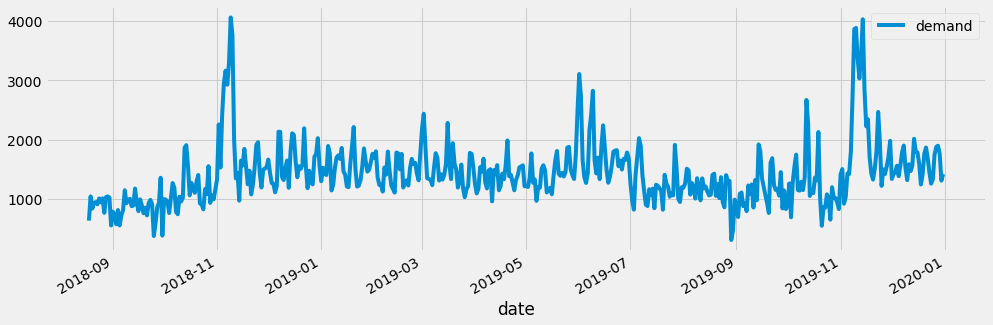

In [11]:
df_train.groupby('date').aggregate({'demand':sum})[:500].plot(figsize=(15,5),grid=True)


<AxesSubplot:xlabel='hour'>

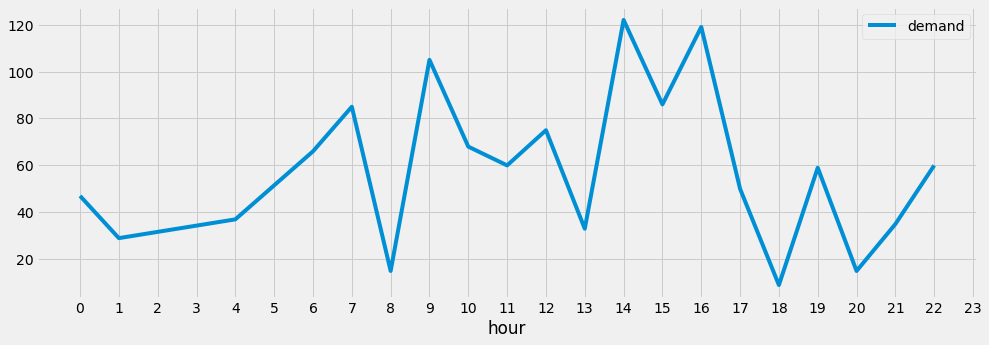

In [12]:
# demand on 20-08-2018
df_train[df_train.index=='20-08-2020'][['demand','hour']].set_index('hour').plot(figsize=(15,5),grid=True,xticks=range(0,24))

<AxesSubplot:xlabel='hour'>

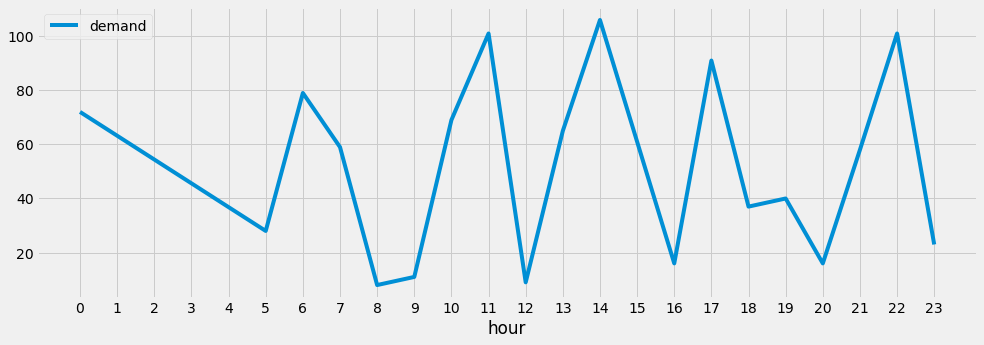

In [13]:
df_train[df_train.index=='20-08-2019'][['demand','hour']].set_index('hour').plot(figsize=(15,5),grid=True,xticks=range(0,24))

# plot demand hour wise 

In [14]:
grouped_hour_data=df_train.groupby(by='hour').aggregate({'demand':sum})

<AxesSubplot:title={'center':'sale'}, xlabel='hour'>

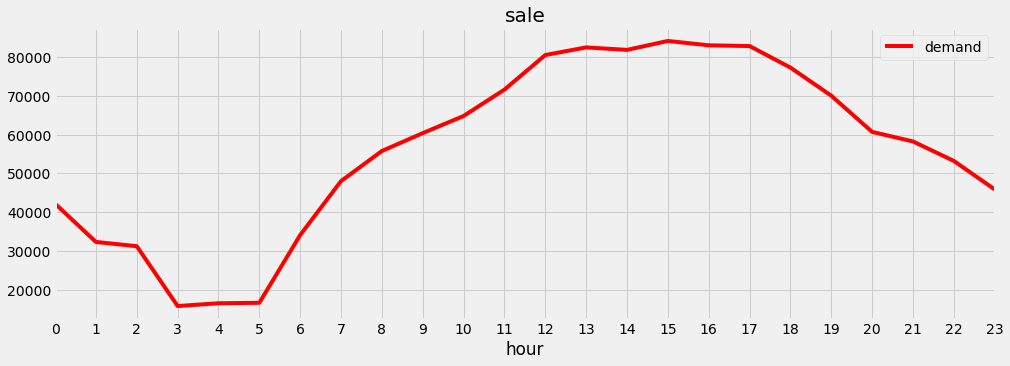

In [15]:
grouped_hour_data.plot(figsize=(15,5), color="red", title='sale',xlim=(0,23),grid=True,xticks=range(0,24))

In [16]:
df_train.shape

(18247, 2)

# Lets Extract some features from the data and do EDA on top of that 

In [17]:
def features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour']=df.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['working day']=df['dayofweek'].apply(lambda x:1 if x<5 else 0)
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
#     df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype('int64')
    return df


In [18]:
df_train=features(df_train)
df_train_features=df_train.drop(columns=['date','demand','year',])

In [19]:
df_train.columns

Index(['hour', 'demand', 'date', 'dayofweek', 'working day', 'month', 'year',
       'dayofyear', 'weekofyear'],
      dtype='object')

In [20]:
df_train=df_train.dropna()

In [21]:
df_train.columns

Index(['hour', 'demand', 'date', 'dayofweek', 'working day', 'month', 'year',
       'dayofyear', 'weekofyear'],
      dtype='object')

# EDA

/Users/surbhi/miniforge3/envs/tf_m1/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/surbhi/miniforge3/envs/tf_m1/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/surbhi/miniforge3/envs/tf_m1/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

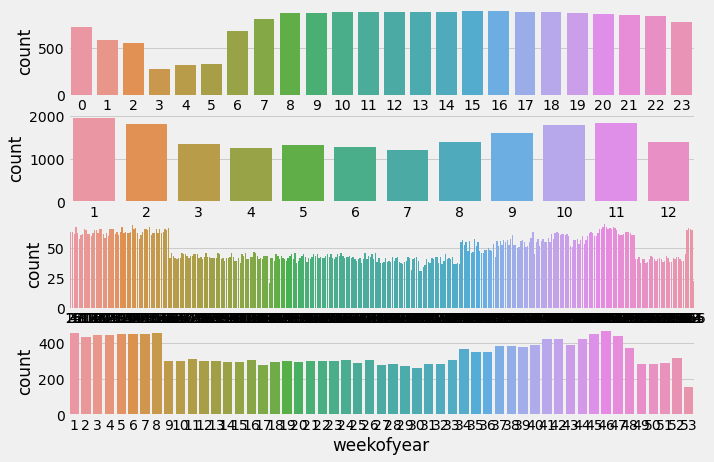

In [22]:
import seaborn as sns

#lets do univariate analysis for all the categorical data
cat_name=['hour', 'month','dayofyear','weekofyear']
j=0
fig, ax = plt.subplots(4,1,figsize=(10,7))
for i in cat_name:
    
    sns.countplot(i,data=df_train,ax=ax[j]) 
    j+=1
    
plt.show()

In [23]:
# what are the range of year available in the Train_data
df_train['year'].unique()

array([2018, 2019, 2020, 2021])

In [24]:
df_train['year'].value_counts()

2019    7286
2020    7145
2018    2511
2021    1305
Name: year, dtype: int64

In [25]:
df_train.head()

,hour,demand,date,dayofweek,working day,month,year,dayofyear,weekofyear
date,,,,,,,,,
2018-08-18,9,91,2018-08-18,5,0,8,2018,230,33
2018-08-18,10,21,2018-08-18,5,0,8,2018,230,33
2018-08-18,13,23,2018-08-18,5,0,8,2018,230,33
2018-08-18,14,104,2018-08-18,5,0,8,2018,230,33
2018-08-18,15,81,2018-08-18,5,0,8,2018,230,33


In [26]:
df_train.tail()

,hour,demand,date,dayofweek,working day,month,year,dayofyear,weekofyear
date,,,,,,,,,
2021-02-28,19,95,2021-02-28,6,0,2,2021,59,8
2021-02-28,20,88,2021-02-28,6,0,2,2021,59,8
2021-02-28,21,39,2021-02-28,6,0,2,2021,59,8
2021-02-28,22,104,2021-02-28,6,0,2,2021,59,8
2021-02-28,23,85,2021-02-28,6,0,2,2021,59,8


# Let look into demand for a year 2018

<AxesSubplot:title={'center':'demand for 2018'}, ylabel='month'>

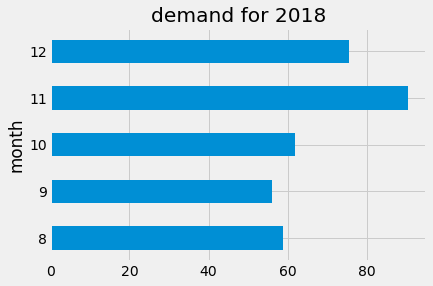

In [27]:
df_train[df_train.year==2018].groupby('month')['demand'].mean().plot(kind='barh',title='demand for 2018')




<AxesSubplot:title={'center':'demand for 2019'}, ylabel='month'>

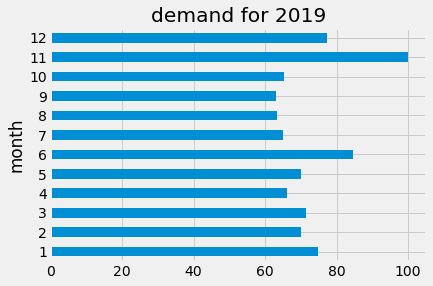

In [28]:
df_train[df_train.year==2019].groupby('month')['demand'].mean().plot(kind='barh',title='demand for 2019')



<AxesSubplot:title={'center':'demand for 2020'}, ylabel='month'>

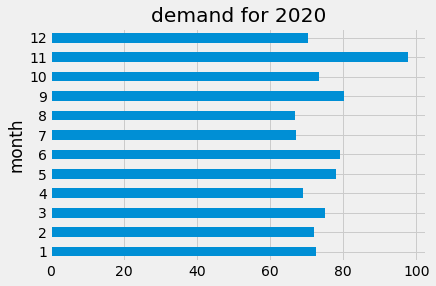

In [29]:
df_train[df_train.year==2020].groupby('month')['demand'].mean().plot(kind='barh',title='demand for 2020')


<AxesSubplot:title={'center':'demand for 2021'}, ylabel='month'>

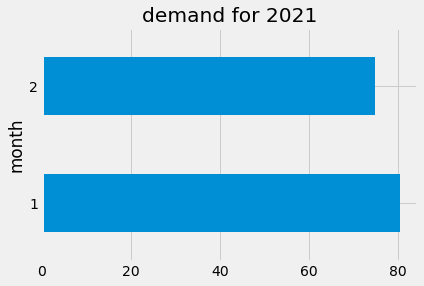

In [30]:
df_train[df_train.year==2021].groupby('month')['demand'].mean().plot(kind='barh',title='demand for 2021')





# plot demand by month 

<AxesSubplot:ylabel='month'>

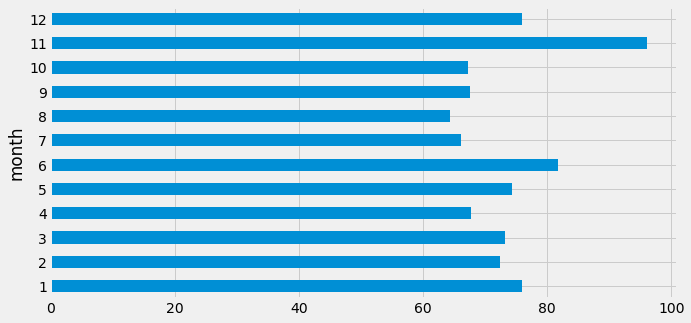

In [31]:
df_train.groupby('month')['demand'].mean().plot(kind='barh',figsize=(10,5))

# plot demand by week day

<AxesSubplot:ylabel='dayofweek'>

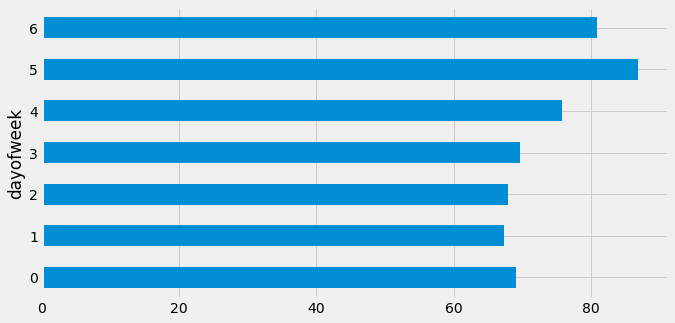

In [32]:
df_train.groupby('dayofweek')['demand'].mean().plot(kind='barh',figsize=(10,5))

In [33]:
df_train

,hour,demand,date,dayofweek,working day,month,year,dayofyear,weekofyear
date,,,,,,,,,
2018-08-18,9,91,2018-08-18,5,0,8,2018,230,33
2018-08-18,10,21,2018-08-18,5,0,8,2018,230,33
2018-08-18,13,23,2018-08-18,5,0,8,2018,230,33
2018-08-18,14,104,2018-08-18,5,0,8,2018,230,33
2018-08-18,15,81,2018-08-18,5,0,8,2018,230,33
...,...,...,...,...,...,...,...,...,...
2021-02-28,19,95,2021-02-28,6,0,2,2021,59,8
2021-02-28,20,88,2021-02-28,6,0,2,2021,59,8
2021-02-28,21,39,2021-02-28,6,0,2,2021,59,8


# Model Building 

In [34]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df_train_features,df_train['demand'],test_size=0.1,shuffle=True)

In [35]:
reg=xgb.XGBRegressor(n_estimators=1000,learning_rate=0.01)
reg.fit(X_train,y_train, eval_set=[(X_train, y_train),(X_test,y_test)],
        early_stopping_rounds=50,
        verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [36]:
# X_train=df_train[df_train['year']<=2020]
# X_test=df_train[df_train['year']>2020]

In [37]:
# X_train.columns
# train=X_train[['hour', 'dayofweek', 'month',
#        'dayofyear', 'dayofmonth', 'weekofyear']]
# y_train=X_train[['demand']]

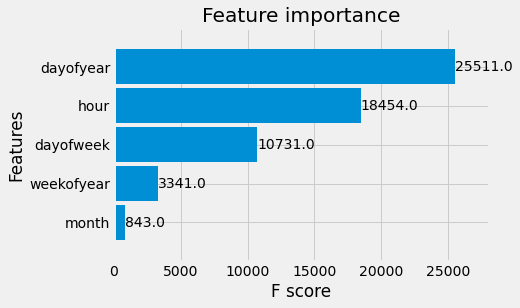

In [38]:
_=plot_importance(reg,height=0.9)

# Prediction on validation set  and Train set and reporting MSER

In [39]:
Prediction_test=reg.predict(X_test)


In [40]:
Prediction_train=reg.predict(X_train)

In [41]:
from sklearn.metrics import mean_squared_error
print("MSER for validation set: ",np.sqrt(mean_squared_error(Prediction_test,y_test)))

MSER for validation set:  33.98983904946255


In [42]:
print("MSER for Train set: ",np.sqrt(mean_squared_error(Prediction_train,y_train)))

MSER for Train set:  30.317137061295245


<AxesSubplot:>

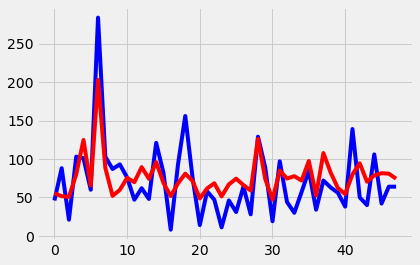

In [43]:
pd.Series(y_train.values)[:48].plot(color='blue')
pd.Series(Prediction_train)[:48].plot(color='red')

<AxesSubplot:>

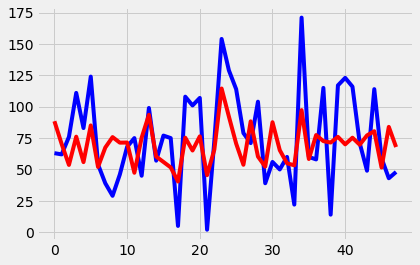

In [44]:
pd.Series(y_test.values)[:48].plot(color='blue')
pd.Series(Prediction_test)[:48].plot(color='red')

# prediction on submission data

In [45]:
df_test=features(df_test)
df_test=df_test.drop(columns=['date','year'])



In [46]:
df_test

,hour,dayofweek,working day,month,dayofyear,weekofyear
date,,,,,,
2021-03-01,0,0,1,3,60,9
2021-03-01,1,0,1,3,60,9
2021-03-01,2,0,1,3,60,9
2021-03-01,3,0,1,3,60,9
2021-03-01,5,0,1,3,60,9
...,...,...,...,...,...,...
2022-03-28,19,0,1,3,87,13
2022-03-28,20,0,1,3,87,13
2022-03-28,21,0,1,3,87,13


In [47]:
test=pd.read_csv('test_hackathon.csv')
test['demand']=np.round(reg.predict(df_test),0)


In [48]:
test

,date,hour,demand
0,2021-03-01,0,64.0
1,2021-03-01,1,57.0
2,2021-03-01,2,57.0
3,2021-03-01,3,57.0
4,2021-03-01,5,56.0
...,...,...,...
7645,2022-03-28,19,73.0
7646,2022-03-28,20,66.0
7647,2022-03-28,21,62.0
7648,2022-03-28,22,53.0


In [49]:
test.to_csv('submission.csv',index=None)